In [1]:
!pip install einops timm flash_attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 20.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cuspa

In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import copy
%matplotlib inline

In [ ]:
task_prompt = '<CAPTION>'                      # Task for generating a simple caption
task_prompt = '<DETAILED_CAPTION>'             # Task for generating a detailed caption


task_prompt = '<OD>'                           # Task for object detection
task_prompt = '<MORE_DETAILED_CAPTION>'        # Task for generating a more detailed caption
task_prompt = '<DENSE_REGION_CAPTION>'         # Task for generating captions for dense regions
task_prompt = '<REGION_PROPOSAL>'              # Task for proposing regions of interest
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'  # Task for grounding captions to phrases
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'  # Task for segmenting based on referring expressions
task_prompt = '<REGION_TO_SEGMENTATION>'       # Task for segmenting specific regions
task_prompt = '<OPEN_VOCABULARY_DETECTION>'    # Task for detecting objects with open vocabulary
task_prompt = '<REGION_TO_CATEGORY>'           # Task for categorizing specific regions


task_prompt = '<OCR>'                          # Task for optical character recognition (OCR)
task_prompt = '<OCR_WITH_REGION>'              # Task for OCR with region specifications


In [2]:
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True).eval()
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


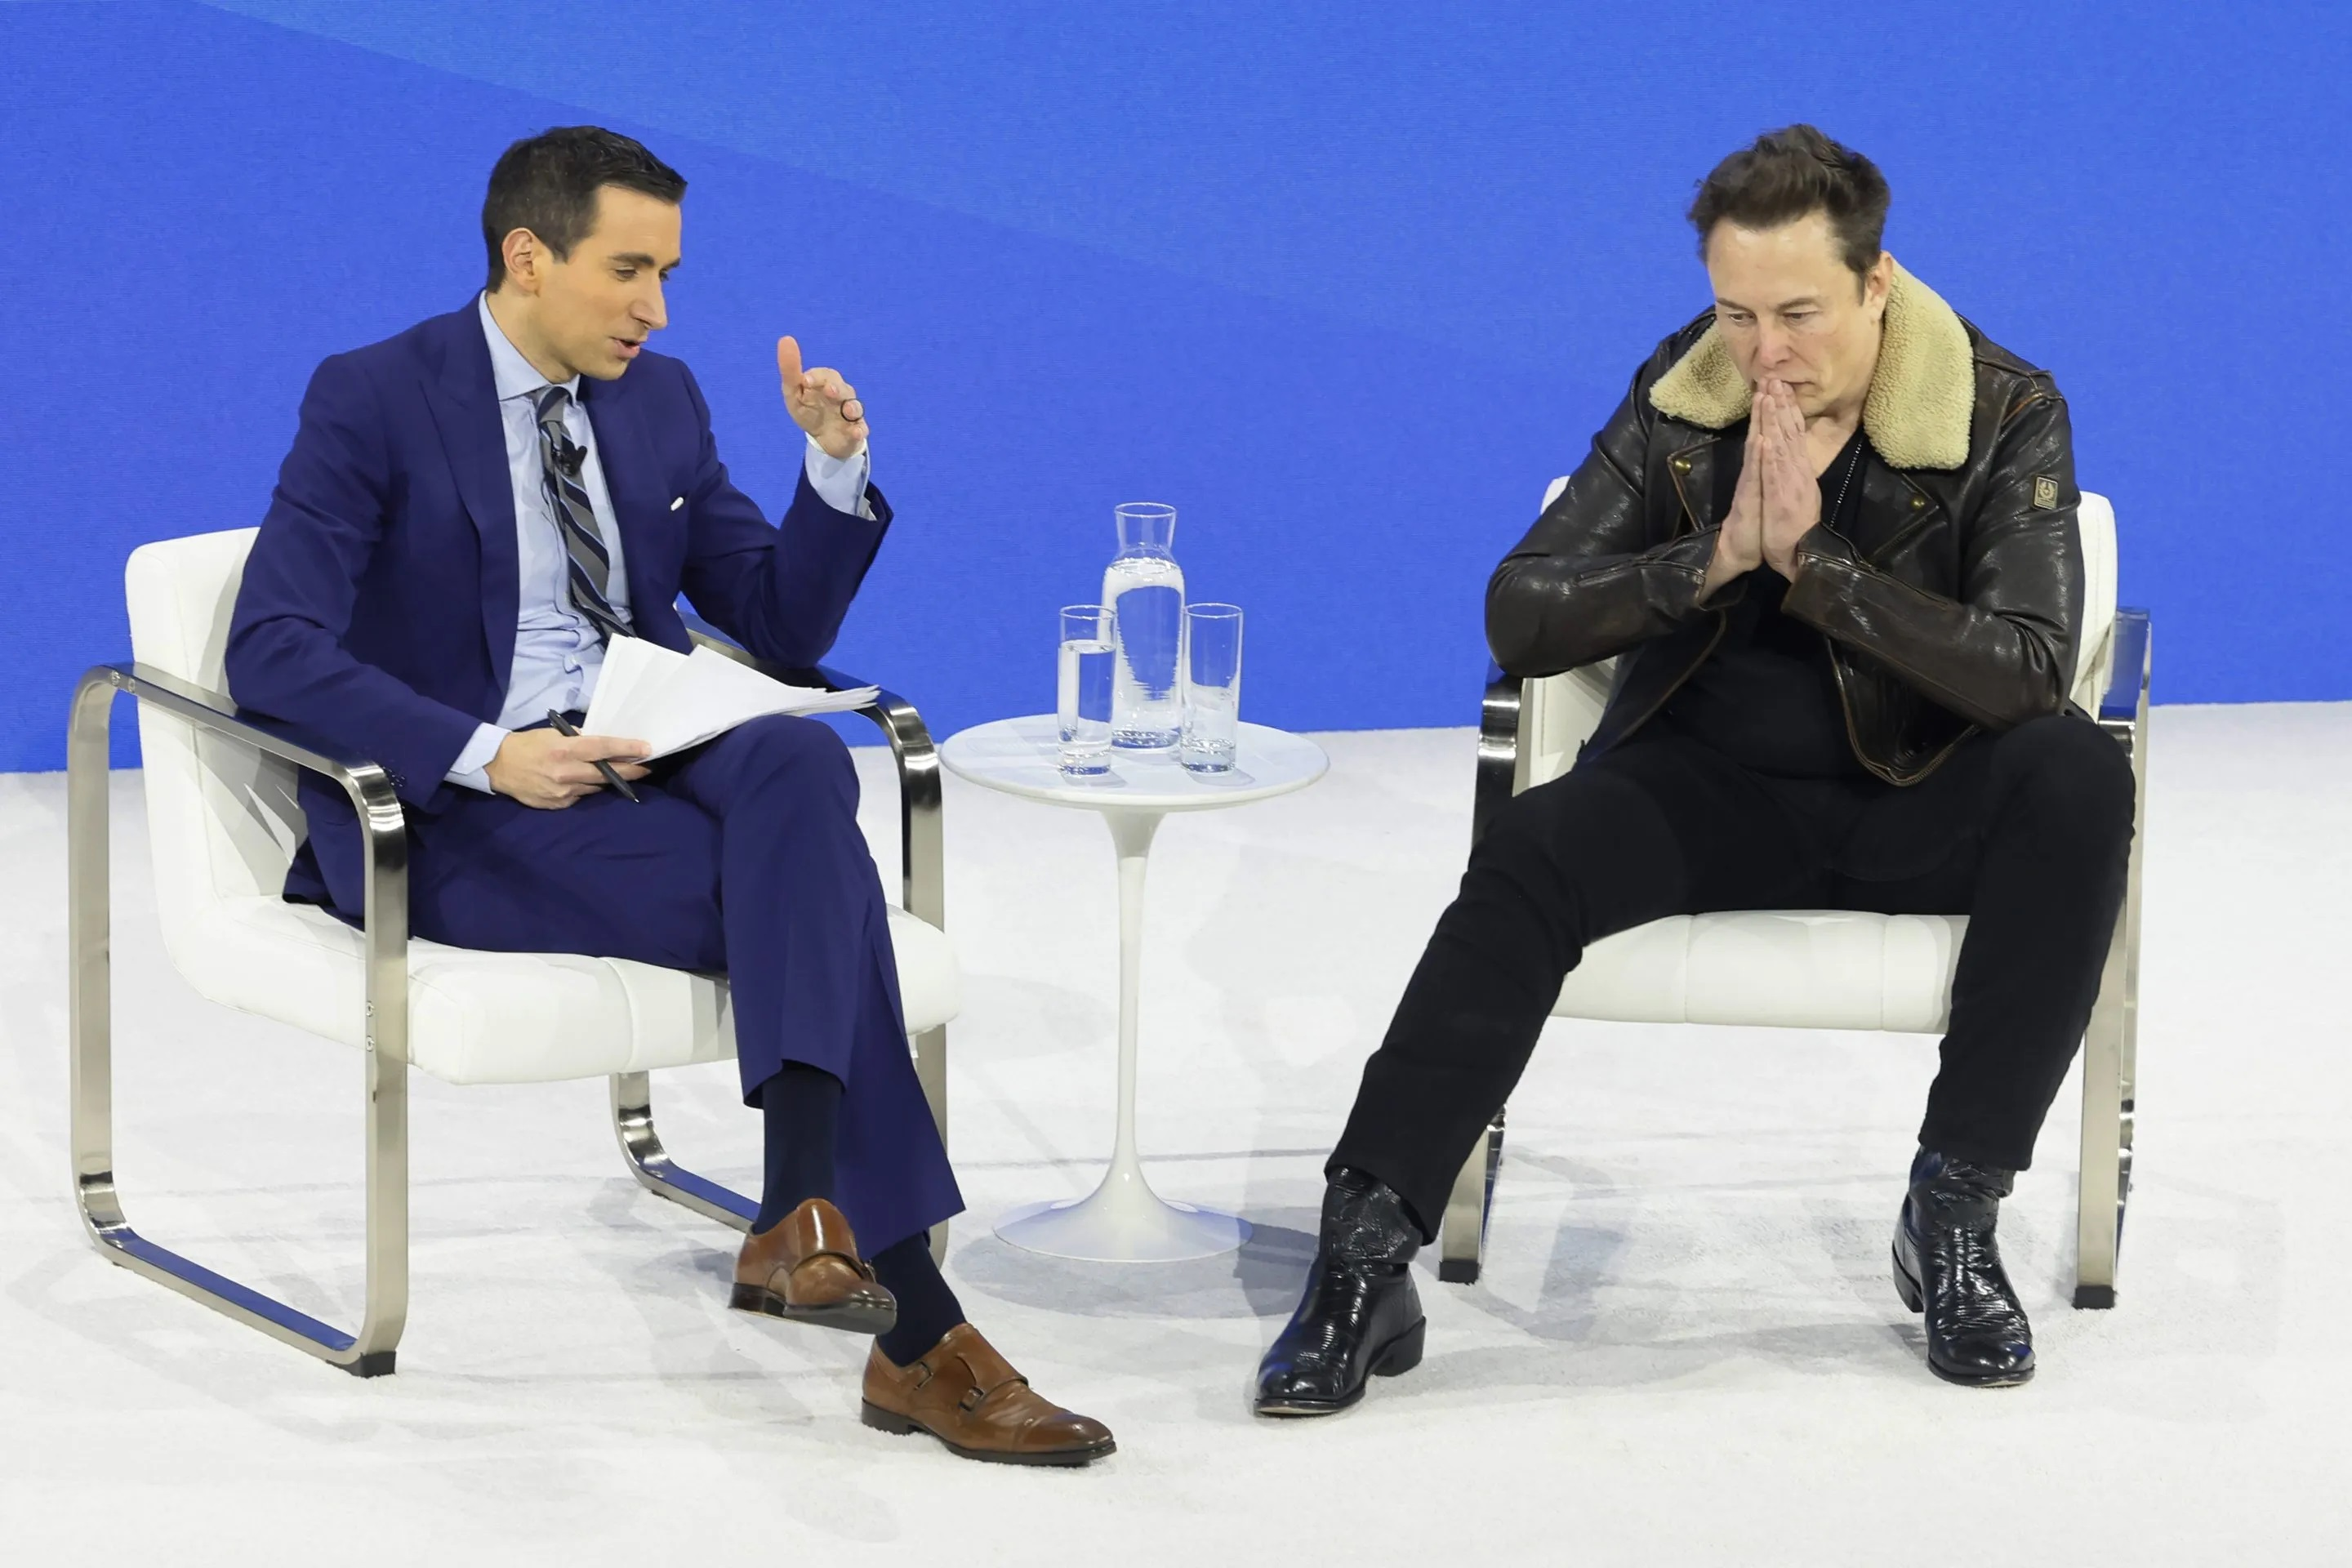

In [3]:
image = Image.open("/content/GettyImages-1821119743-e1701354456357.jpg")
image

In [4]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [5]:
task_prompt = '<OD>'
results = run_example(task_prompt)
print(results)

{'<OD>': {'bboxes': [[76.31999969482422, 642.239990234375, 1193.760009765625, 1688.6400146484375], [1527.840087890625, 1435.199951171875, 1766.880126953125, 1738.5599365234375], [1038.239990234375, 1617.5999755859375, 1375.2000732421875, 1800.0], [2308.320068359375, 1408.3199462890625, 2509.920166015625, 1700.159912109375], [888.4800415039062, 1464.0, 1110.239990234375, 1636.7999267578125], [263.52001953125, 150.72000122070312, 1378.080078125, 1796.159912109375], [1533.60009765625, 150.72000122070312, 2628.0, 1736.6400146484375], [269.2799987792969, 356.1600036621094, 1185.1199951171875, 1546.5599365234375], [1144.800048828125, 868.7999877929688, 1637.280029296875, 1548.47998046875], [1622.8800048828125, 863.0399780273438, 2622.239990234375, 1523.52001953125]], 'labels': ['chair', 'footwear', 'footwear', 'footwear', 'footwear', 'man', 'man', 'suit', 'table', 'trousers']}}


In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

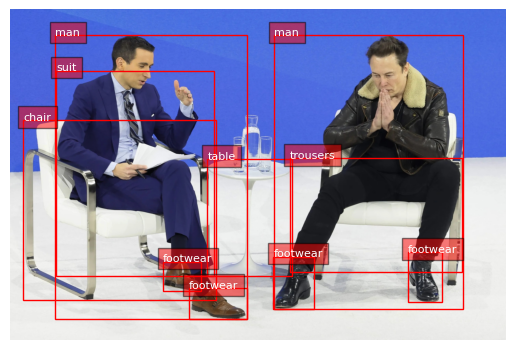

In [8]:
plot_bbox(image, results['<OD>'])

In [9]:
# Extracting the bounding boxes and labels
bboxes = results['<OD>']['bboxes']
labels = results['<OD>']['labels']
# Combining bounding boxes and labels into a list of tuples
boxes_with_labels = list(zip(bboxes, labels))

# Displaying the result
for bbox, label in boxes_with_labels:
    print(f" {label}, {bbox}")

 chair, [76.31999969482422, 642.239990234375, 1193.760009765625, 1688.6400146484375]
 footwear, [1527.840087890625, 1435.199951171875, 1766.880126953125, 1738.5599365234375]
 footwear, [1038.239990234375, 1617.5999755859375, 1375.2000732421875, 1800.0]
 footwear, [2308.320068359375, 1408.3199462890625, 2509.920166015625, 1700.159912109375]
 footwear, [888.4800415039062, 1464.0, 1110.239990234375, 1636.7999267578125]
 man, [263.52001953125, 150.72000122070312, 1378.080078125, 1796.159912109375]
 man, [1533.60009765625, 150.72000122070312, 2628.0, 1736.6400146484375]
 suit, [269.2799987792969, 356.1600036621094, 1185.1199951171875, 1546.5599365234375]
 table, [1144.800048828125, 868.7999877929688, 1637.280029296875, 1548.47998046875]
 trousers, [1622.8800048828125, 863.0399780273438, 2622.239990234375, 1523.52001953125]


In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_bbox(image, data, filtered_name):
    """
    Plots bounding boxes on the given image for objects with the specified label.

    Parameters:
    - image: The image on which to plot the bounding boxes.
    - data: A dictionary containing 'bboxes' and 'labels'.
    - filtered_name: The label to filter and draw bounding boxes for.
    """
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        if label == filtered_name:  # Check if the label matches the filtered name
            # Unpack the bounding box coordinates
            x1, y1, x2, y2 = bbox
            # Create a Rectangle patch
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
            # Add the rectangle to the Axes
            ax.add_patch(rect)
            # Annotate the label
            plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()



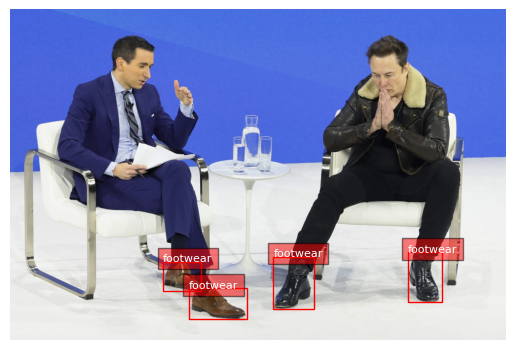

In [11]:
data = results['<OD>']  # Your data dictionary
filtered_name = 'footwear'  # The label you want to filter by
plot_bbox(image, data, filtered_name)


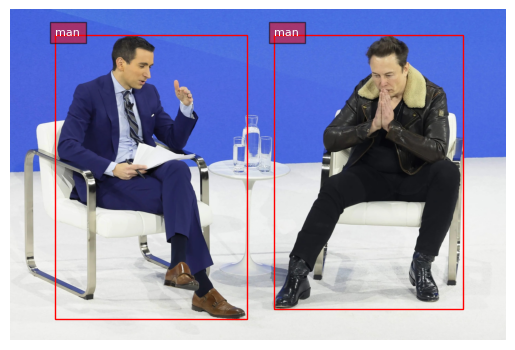

In [12]:
data = results['<OD>']  # Your data dictionary
filtered_name = 'man'  # The label you want to filter by
plot_bbox(image, data, filtered_name)